# **Travel Insurance Claims Prediction**

Hi there! this notebook shows the analysis to create a classification model of travel insurance claims using resampling methods, XGBoost, and Bayesian Optimization. The final result of the best XGBoost model will also be interpreted using feature importance and SHAP.

# Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import shap
import seaborn as sns

import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import *
from bayes_opt import BayesianOptimization
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

# **Load Travel Insurance Dataset**

In [2]:
travel_df=pd.read_csv('travel insurance.csv')

In [3]:
travel_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


# Exploratory Data Analysis

In [4]:
travel_df.shape

(63326, 11)

In [5]:
travel_df.dtypes

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

In [6]:
travel_df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

In [7]:
travel_df.describe()

,Duration,Net Sales,Commision (in value),Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [8]:
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_object_dtype
for col in travel_df.columns:
    if is_numeric_dtype(travel_df[col]):
        print('%s:' % (col))
        print('\t Mean = %.2f' % travel_df[col].mean())
        print('\t Standard deviation = %.2f' % travel_df[col].std())
        print('\t Minimum = %.2f' % travel_df[col].min())
        print('\t Maximum = %.2f' % travel_df[col].max())
    if is_object_dtype(travel_df[col]):
        print(travel_df[col].value_counts())

Agency
EPX    35119
CWT     8580
C2B     8267
JZI     6329
SSI     1056
JWT      749
RAB      725
LWC      689
TST      528
KML      392
ART      331
CCR      194
CBH      101
TTW       98
CSR       86
ADM       82
Name: count, dtype: int64
Agency Type
Travel Agency    45869
Airlines         17457
Name: count, dtype: int64
Distribution Channel
Online     62219
Offline     1107
Name: count, dtype: int64
Product Name
Cancellation Plan                       18630
2 way Comprehensive Plan                13158
Rental Vehicle Excess Insurance          8580
Basic Plan                               5469
Bronze Plan                              4049
1 way Comprehensive Plan                 3331
Value Plan                               2715
Silver Plan                              2249
Annual Silver Plan                       1423
Ticket Protector                         1056
Travel Cruise Protect                     527
Comprehensive Plan                        364
Gold Plan                    

In [9]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


# Checking the null values if any

In [10]:
#Checking the null values if any
travel_df.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64

In [11]:
#checking unique values
for i in travel_df.columns:
    print({i:travel_df[i].unique()})

{'Agency': array(['CBH', 'CWT', 'JZI', 'KML', 'EPX', 'C2B', 'JWT', 'RAB', 'SSI',
       'ART', 'CSR', 'CCR', 'ADM', 'LWC', 'TTW', 'TST'], dtype=object)}
{'Agency Type': array(['Travel Agency', 'Airlines'], dtype=object)}
{'Distribution Channel': array(['Offline', 'Online'], dtype=object)}
{'Product Name': array(['Comprehensive Plan', 'Rental Vehicle Excess Insurance',
       'Value Plan', 'Basic Plan', 'Premier Plan',
       '2 way Comprehensive Plan', 'Bronze Plan', 'Silver Plan',
       'Annual Silver Plan', 'Cancellation Plan',
       '1 way Comprehensive Plan', 'Ticket Protector', '24 Protect',
       'Gold Plan', 'Annual Gold Plan',
       'Single Trip Travel Protect Silver',
       'Individual Comprehensive Plan',
       'Spouse or Parents Comprehensive Plan',
       'Annual Travel Protect Silver',
       'Single Trip Travel Protect Platinum',
       'Annual Travel Protect Gold', 'Single Trip Travel Protect Gold',
       'Annual Travel Protect Platinum', 'Child Comprehensive Plan

In [12]:
travel_df_c=pd.DataFrame.copy(travel_df)

In [13]:
travel_df_c=travel_df_c.drop(['Gender'],axis=1)

In [14]:
travel_df.shape

(63326, 11)

In [15]:
travel_df_c.shape

(63326, 10)

In [16]:
travel_df_c.isnull().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Claim                   0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
dtype: int64

In [17]:
colname=[]
for x in travel_df_c.columns:
    if travel_df_c[x].dtype=='object':
        colname.append(x)
colname   


['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Claim',
 'Destination']

In [18]:
travel_df_c['Claim'].value_counts()

Claim
No     62399
Yes      927
Name: count, dtype: int64

<Axes: xlabel='Agency', ylabel='count'>

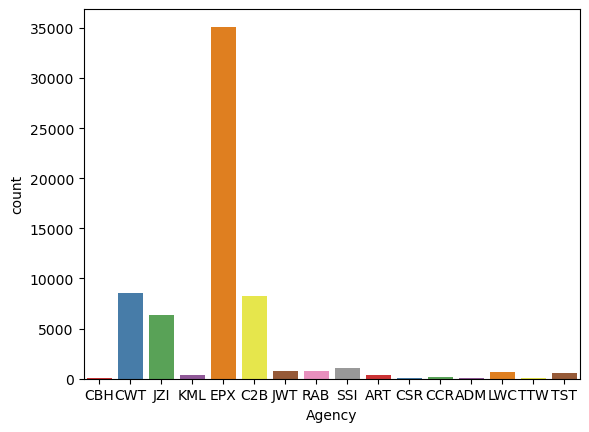

In [19]:
#count plot is useful for visualising the frequency distribution of discrete or categorical variable
sns.countplot(x='Agency',data=travel_df_c,palette='Set1')

<Axes: xlabel='Agency Type', ylabel='count'>

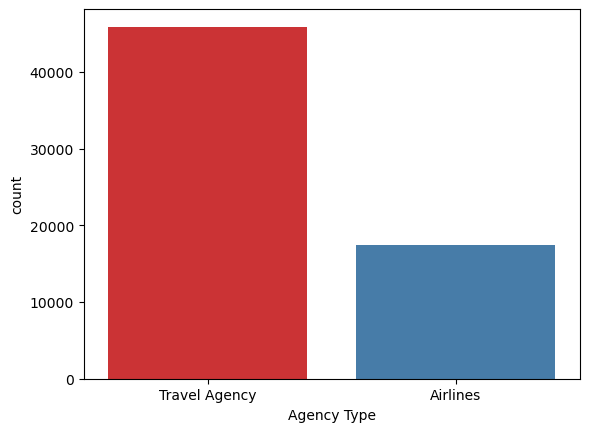

In [20]:
#count plot is useful for visualising the frequency distribution of discrete or categorical variable
sns.countplot(x='Agency Type',data=travel_df_c,palette='Set1')

<Axes: xlabel='Distribution Channel', ylabel='count'>

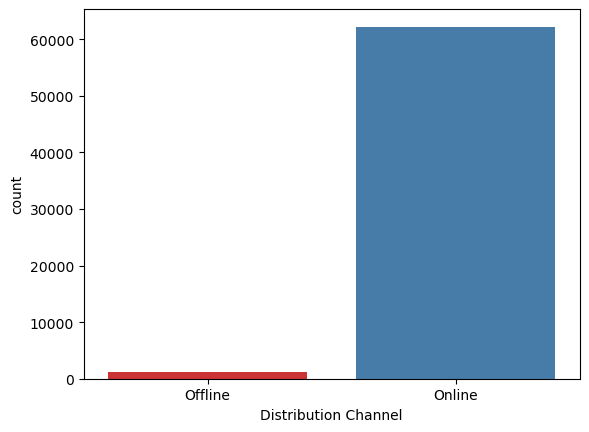

In [21]:
#count plot is useful for visualising the frequency distribution of discrete or categorical variable
sns.countplot(x='Distribution Channel',data=travel_df_c,palette='Set1')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'Comprehensive Plan'),
  Text(1, 0, 'Rental Vehicle Excess Insurance'),
  Text(2, 0, 'Value Plan'),
  Text(3, 0, 'Basic Plan'),
  Text(4, 0, 'Premier Plan'),
  Text(5, 0, '2 way Comprehensive Plan'),
  Text(6, 0, 'Bronze Plan'),
  Text(7, 0, 'Silver Plan'),
  Text(8, 0, 'Annual Silver Plan'),
  Text(9, 0, 'Cancellation Plan'),
  Text(10, 0, '1 way Comprehensive Plan'),
  Text(11, 0, 'Ticket Protector'),
  Text(12, 0, '24 Protect'),
  Text(13, 0, 'Gold Plan'),
  Text(14, 0, 'Annual Gold Plan'),
  Text(15, 0, 'Single Trip Travel Protect Silver'),
  Text(16, 0, 'Individual Comprehensive Plan'),
  Text(17, 0, 'Spouse or Parents Comprehensive Plan'),
  Text(18, 0, 'Annual Travel Protect Silver'),
  Text(19, 0, 'Single Trip Travel Protect Platinum'),
  Text(20, 0, 'Annual Travel Protect Gold'),
  Text(21, 0, 'Single Trip Travel Protect Gold'),
  Text(22, 0, '

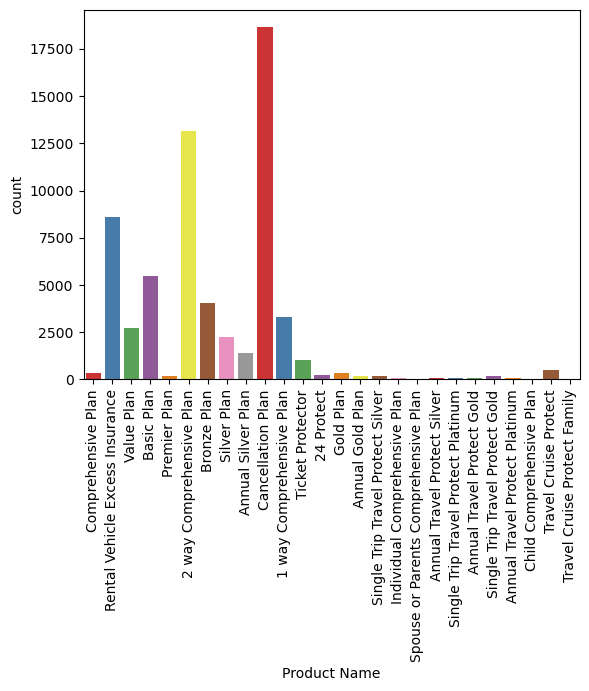

In [22]:
#count plot is useful for visualising the frequency distribution of discrete or categorical variable
sns.countplot(x='Product Name',data=travel_df_c,palette='Set1')

#rotate x labels
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

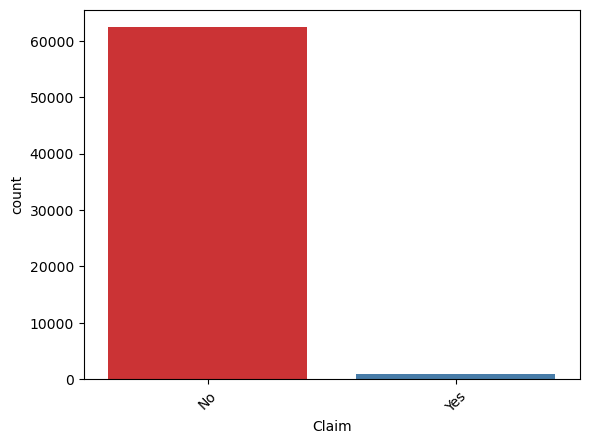

In [23]:
#count plot is useful for visualising the frequency distribution of discrete or categorical variable
sns.countplot(x='Claim',data=travel_df_c,palette='Set1')

#rotate x labels
plt.xticks(rotation=45)

# Checking for outliers

In [24]:
def col_names(stroke):
    # Check if each column is numeric
    is_numeric = np.vectorize(lambda x: np.issubdtype(x, np.number))(travel_df_c.dtypes)
    
    # Select numerical columns
    num_cols = travel_df_c.columns[is_numeric].tolist()
    
    # Select categorical columns
    cat_cols = travel_df_c.columns[~is_numeric].tolist()
    
    # Select numerical but categorical columns
    num_but_cat = [col for col in num_cols if travel_df_c[col].nunique() < 12]
    cat_cols = num_but_cat + cat_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    # Select categorical but cardinal columns
    cat_but_car = [col for col in cat_cols if travel_df_c[col].nunique() > 12]
    
    print(f"Numerical Cols: {num_cols} \nCategorical Cols: {cat_cols} \nNumerical but Categorical: {num_but_cat} \nCategorical but Cardinal: {cat_but_car}") 
    return num_cols, cat_cols


In [25]:
num_cols, cat_cols = col_names(travel_df_c)

Numerical Cols: ['Duration', 'Net Sales', 'Commision (in value)', 'Age'] 
Categorical Cols: ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Destination'] 
Numerical but Categorical: [] 
Categorical but Cardinal: ['Agency', 'Product Name', 'Destination']


# Checking for columns with numerical variables

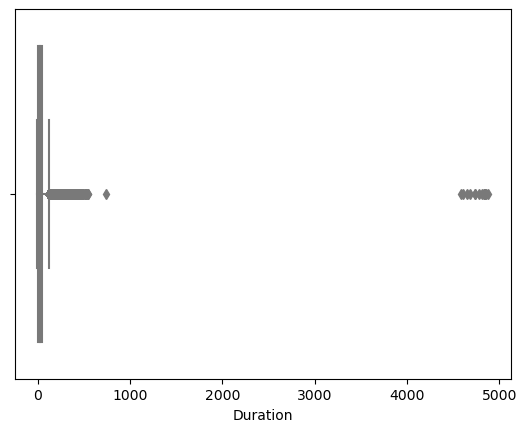

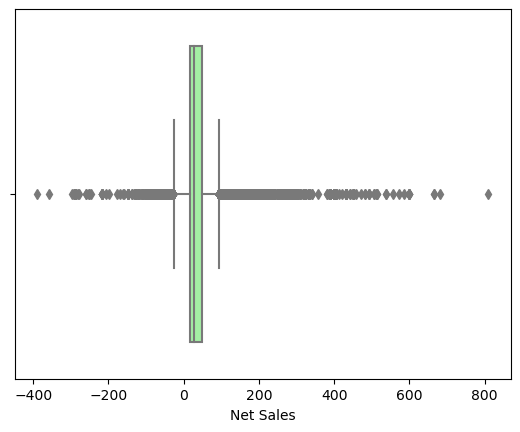

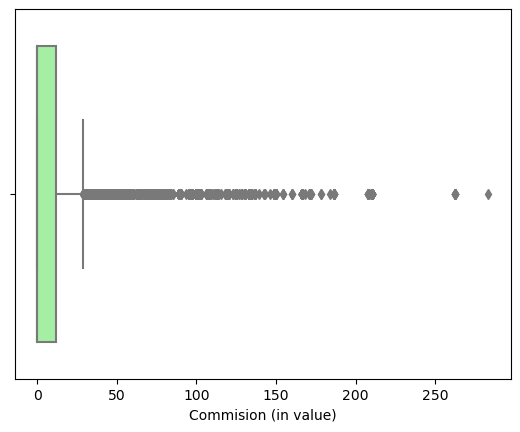

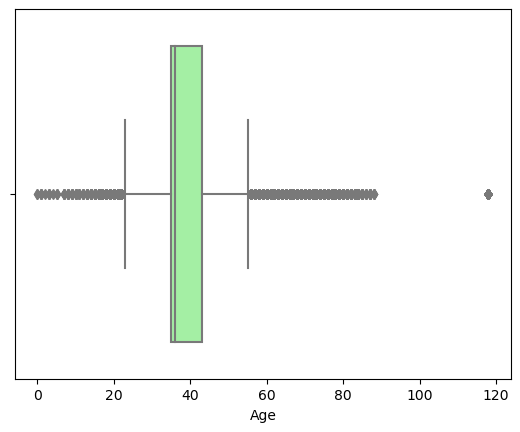

In [26]:
#To check for outliers we used boxplot:-
for col in num_cols:
    sns.boxplot(x=travel_df_c[col], data=travel_df_c, color="palegreen")
    plt.show(block=True)

In [27]:
def check_outliers(travel_df_c, numerical_cols, low_threshold=0.1, up_threshold=0.9):
    outlier_cols = []
    for col in numerical_cols:
        q1 = travel_df_c[col].quantile(low_threshold)
        q3 = travel_df_c[col].quantile(up_threshold)
        interquantile = q3 - q1
        up_limit = q3 + 1.5 * interquantile
        low_limit = q1 - 1.5 * interquantile
        if travel_df_c[(travel_df_c[col] > up_limit) | (travel_df_c[col] < low_limit)].any(axis=None):
            outlier_cols.append(col)
    if not outlier_cols:
        print("There is no outliers")
    return outlier_cols

In [28]:
outlier_cols = check_outliers(travel_df_c, num_cols)
print(outlier_cols)

['Duration', 'Net Sales', 'Commision (in value)', 'Age']


# Checking for numerical variables that impact the target variable Claim

In [29]:
for col in num_cols:
    print(travel_df_c.groupby("Claim").agg({col:"mean"}), end="\n\n")

         Duration
Claim            
No      48.403853
Yes    110.788565

       Net Sales
Claim           
No     39.904660
Yes    94.374423

       Commision (in value)
Claim                      
No                 9.571755
Yes               25.846419

             Age
Claim           
No     39.989824
Yes    38.634304



#### With respect to numerical variables from this we can get an idea that "Duration", "Net Sales" and " Commision (in value)" shows positive impact on Claim

# Data Preprocessing

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for x in colname:
    travel_df_c[x]= le.fit_transform(travel_df_c[x])

In [31]:
travel_df_c.head(5)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,3,1,0,12,0,186,79,-29.0,9.57,81
1,3,1,0,12,0,186,79,-29.0,9.57,71
2,6,1,1,16,0,65,4,-49.5,29.70,32
3,6,1,1,16,0,60,4,-39.6,23.76,32
4,6,1,1,16,0,79,61,-19.8,11.88,41


<Axes: >

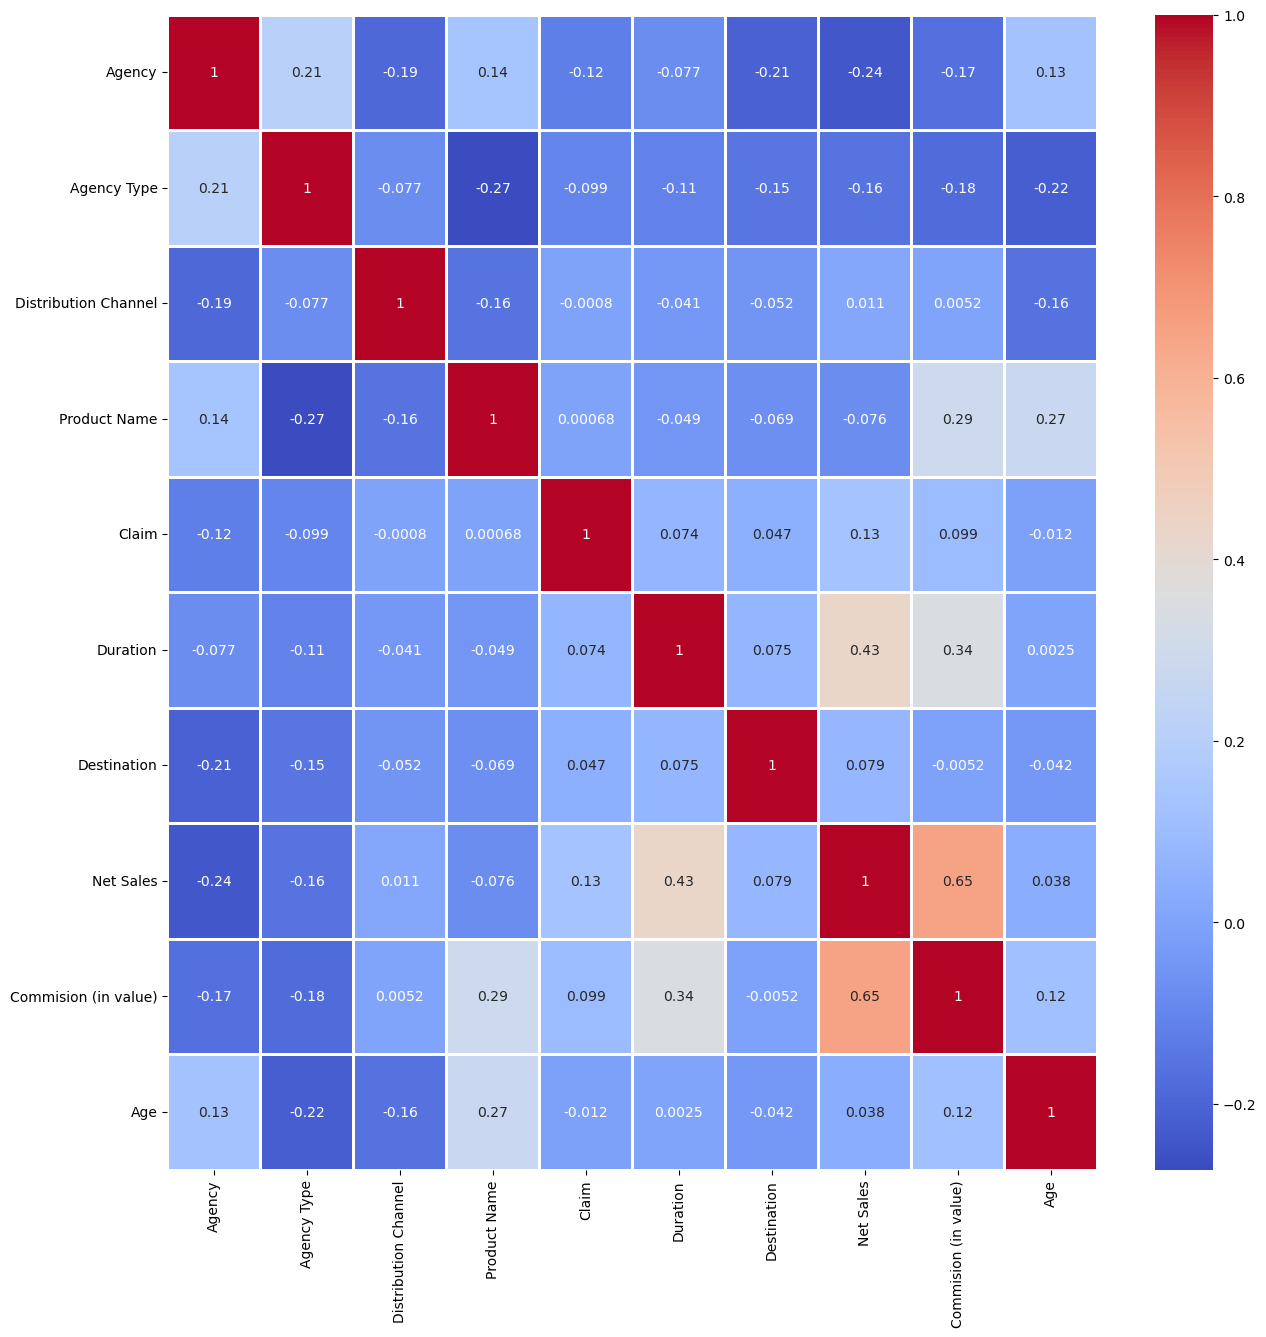

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(travel_df_c.corr(),annot=True,cmap="coolwarm",linewidths=2)

# Data Splitting

In this study, an 80:20 split ratio will be used.

In [33]:
from sklearn.model_selection import train_test_split

x = travel_df_c.drop(["Claim"], axis=1)
y = travel_df_c["Claim"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [34]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50660, 9)
(50660,)
(12666, 9)
(12666,)


# Imbalanced Data: Claim vs. No Claim

The main problem in this study is the existence of imbalanced data in the target feature. The code below shows that the number of claims is only 1% of the total number of policies. In this study, several methods of oversampling, undersampling, and combination resampling will compared and later be used to tackle this problem.

In [35]:
# 0 = No Claim
# 1 = Claim
travel_df_c['Claim'].value_counts()

Claim
0    62399
1      927
Name: count, dtype: int64

 The comparison is done using the XGBoost ROC-AUC value generated by cross validation score of 5-fold CV. Notice that the resampling process is done **only on training data**. A common mistake is to do the resampling before train-test splitting which generates an almost perfect model, but with misleading results. This phenomenon is usually called "Data Leakage".

# Initializing an XGBRFClassifier object for classification using the XGBoost library

In [36]:
model = xgb.XGBRFClassifier(random_state=100)

# Some oversampling methods

In [37]:

over_methods = [
    SMOTE(random_state=100),
    BorderlineSMOTE(random_state=100),
    SVMSMOTE(random_state=100)
]
# cross validation (oversampling)
for methods in over_methods:
    x_train_res, y_train_res = methods.fit_resample(x_train, y_train.ravel())
    score = cross_val_score(model, x_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
    print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  SMOTE(random_state=100)  is  0.9079681238213675
The XGB ROC-AUC Mean Score for  BorderlineSMOTE(random_state=100)  is  0.9459268530233871
The XGB ROC-AUC Mean Score for  SVMSMOTE(random_state=100)  is  0.9810073235313377


# Some undersampling methods

In [38]:

under_methods = [
    RandomUnderSampler(random_state=100),
    NearMiss(),
    EditedNearestNeighbours()
]
# cross validation (undersampling)
for methods in under_methods:
    x_train_res, y_train_res = methods.fit_resample(x_train, y_train.ravel())
    score = cross_val_score(model, x_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
    print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  RandomUnderSampler(random_state=100)  is  0.8191522123974977
The XGB ROC-AUC Mean Score for  NearMiss()  is  0.9094075049072664
The XGB ROC-AUC Mean Score for  EditedNearestNeighbours()  is  0.8370837384478286


# Some combination methods

In [39]:

comb_methods = [
    SMOTEENN(random_state=100),
    SMOTETomek(random_state=100)
]
# cross validation (combination)
for methods in comb_methods:
    x_train_res, y_train_res = methods.fit_resample(x_train, y_train.ravel())
    score = cross_val_score(model, x_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
    print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  SMOTEENN(random_state=100)  is  0.934757103026568
The XGB ROC-AUC Mean Score for  SMOTETomek(random_state=100)  is  0.9109286217213703


From the codes above, we can see which one is the best method for each resampling categories. Next, we will use these three methods to model the claims using XGBoost.

In [40]:
# (Based on above examination)

# Best oversampling
bsm = BorderlineSMOTE(random_state=100)
x_train_res_bsm, y_train_res_bsm = bsm.fit_resample(x_train, y_train.ravel())

# Best undersampling
rus = RandomUnderSampler(random_state=100)
x_train_res_rus, y_train_res_rus = rus.fit_resample(x_train, y_train.ravel())

# Best combination
com = SMOTEENN(random_state=100)
x_train_res_com, y_train_res_com = com.fit_resample(x_train, y_train.ravel())

# **Hyperparameter Tuning using Bayesian Optimization**

Hyperparameter tuning is an essential process in XGBoost modelling due to the numerous parameters that XGBoost has. Contrary to GridSearchCV or Random Search method that people commonly use, Bayesian Optimization doesn't pick the parameters from the hyperparameter space randomly. Instead, it will form a surrogate function to replicate the black-box function of XGBoost ROC-AUC that we want to maximize and sequentially pick the appropriate parameters until the ROC-AUC value is maximized

In [41]:
# Hyperparameter Space
hps = {
  'min_child_weight':(3, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 20),
  'learning_rate': (0, 1)
}

# Base function that will be optimized
def hyper_xgboost(max_depth, subsample, colsample_bytree,min_child_weight, gamma, learning_rate):
    params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread':-1
     }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    params['learning_rate'] = learning_rate

    scores = xgb.cv(params, dtrain, num_boost_round=500,verbose_eval=False,   #XGBoost requires data to be transformed into DMatrix
                    early_stopping_rounds=10, nfold=5)
    return scores['test-auc-mean'].iloc[-1]


# BorderlineSMOTE

In [42]:
# BorderlineSMOTE
dtrain = xgb.DMatrix(x_train_res_bsm, y_train_res_bsm, feature_names=x_train_res_bsm.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9539    | 0.4753    | 7.203     | 0.0001144 | 7.442     | 5.495     | 0.5462    |
| 2         | 0.9927    | 0.2676    | 3.456     | 0.3968    | 11.7      | 10.13     | 0.8426    |
| 3         | 0.9923    | 0.2908    | 3.604     | 0.8477    | 11.16     | 10.07     | 0.6585    |
| 4         | 0.9918    | 0.256     | 0.233     | 1.0       | 11.1      | 15.52     | 0.5       |
| 5         | 0.9916    | 1.0       | 6.831     | 1.0       | 15.75     | 16.1      | 0.5       |
| 6         | 0.9931    | 1.0       | 0.0       | 1.0       | 19.63     | 11.96     | 0.5       |
| 7         | 0.5       | 0.1       | 0.0       | 0.0       | 20.0      | 20.0      | 0.5       |


In [43]:
optimizer.max['params']

{'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 1.0,
 'max_depth': 19.630332446593826,
 'min_child_weight': 11.961110665952585,
 'subsample': 0.5}

In [44]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'learning_rate': 1.0,
    'max_depth': 20,
    'min_child_weight': 12,
    'subsample': 0.5,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_ov =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_ov.fit(x_train_res_bsm, y_train_res_bsm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [45]:
y_pred = xgbr_ov.predict(x_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.9557081951681667
ROC AUC Score 0.5689547739978305
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12497
           1       0.06      0.17      0.09       169

    accuracy                           0.96     12666
   macro avg       0.53      0.57      0.54     12666
weighted avg       0.98      0.96      0.97     12666



# RandomUnderSampling

In [46]:
# RandomUnderSampling
dtrain = xgb.DMatrix(x_train_res_rus, y_train_res_rus, feature_names=x_train_res_rus.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.811     | 0.4753    | 7.203     | 0.0001144 | 7.442     | 5.495     | 0.5462    |
| 2         | 0.8195    | 0.2676    | 3.456     | 0.3968    | 11.7      | 10.13     | 0.8426    |
| 3         | 0.8126    | 0.2908    | 3.604     | 0.8477    | 11.16     | 10.07     | 0.6585    |
| 4         | 0.8021    | 0.6379    | 3.184     | 0.6631    | 10.07     | 5.927     | 0.6515    |
| 5         | 0.8219    | 0.6407    | 3.13      | 0.2379    | 11.88     | 9.838     | 0.8349    |
| 6         | 0.5       | 0.3325    | 2.99      | 0.0       | 13.11     | 10.29     | 1.0       |
| 7         | 0.5       | 0.7644    | 3.305     | 0.0       | 10.88     | 9.264     | 1.0       |


In [47]:
optimizer.max['params']

{'colsample_bytree': 0.6407233670048761,
 'gamma': 3.130168289497066,
 'learning_rate': 0.23786255893901742,
 'max_depth': 11.88284450591425,
 'min_child_weight': 9.838071142786292,
 'subsample': 0.834883131858181}

In [48]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.6407233670048761,
    'gamma': 3.130168289497066,
    'learning_rate': 0.23786255893901742,
    'max_depth': 12,
    'min_child_weight': 10,
    'subsample': 0.834883131858181,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_un =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_un.fit(x_train_res_rus, y_train_res_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6407233670048761, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.130168289497066, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23786255893901742, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [51]:
y_pred = xgbr_un.predict(x_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.7490920574767093
ROC AUC Score 0.7473509618639835
              precision    recall  f1-score   support

           0       1.00      0.75      0.85     12497
           1       0.04      0.75      0.07       169

    accuracy                           0.75     12666
   macro avg       0.52      0.75      0.46     12666
weighted avg       0.98      0.75      0.84     12666



# SMOTEENN

In [54]:
# SMOTEENN
dtrain = xgb.DMatrix(x_train_res_com, y_train_res_com, feature_names=x_train_res_com.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9465    | 0.4753    | 7.203     | 0.0001144 | 7.442     | 5.495     | 0.5462    |
| 2         | 0.9961    | 0.2676    | 3.456     | 0.3968    | 11.7      | 10.13     | 0.8426    |
| 3         | 0.9952    | 0.2908    | 3.604     | 0.8477    | 11.16     | 10.07     | 0.6585    |
| 4         | 0.9955    | 0.2583    | 0.1369    | 1.0       | 11.45     | 15.56     | 0.5       |
| 5         | 0.9845    | 0.1       | 6.697     | 1.0       | 16.46     | 16.01     | 0.5       |
| 6         | 0.9982    | 1.0       | 0.0       | 1.0       | 17.98     | 10.01     | 0.5       |
| 7         | 0.9917    | 0.1       | 0.0       | 1.0       | 20.0      | 3.0       | 1.0       |


In [55]:
optimizer.max['params']

{'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 1.0,
 'max_depth': 17.980979227252675,
 'min_child_weight': 10.011939752287939,
 'subsample': 0.5}

In [56]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'learning_rate': 1.0,
    'max_depth': 18,
    'min_child_weight': 10,
    'subsample': 0.5,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_com =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_com.fit(x_train_res_com, y_train_res_com)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [57]:
y_pred = xgbr_un.predict(x_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.7490920574767093
ROC AUC Score 0.7473509618639835
              precision    recall  f1-score   support

           0       1.00      0.75      0.85     12497
           1       0.04      0.75      0.07       169

    accuracy                           0.75     12666
   macro avg       0.52      0.75      0.46     12666
weighted avg       0.98      0.75      0.84     12666



From the three results above, we can conclude that RandomUnderSampling and SMOTEENN will generate the highest ROC-AUC score among the other methods. Even though the accuracy score is not the highest, the main thing that is focused in this study is the ability of the model to predict the minority class (claims).

In [52]:
# After re-running xgb modelling for RandomUnderSampling
print(confusion_matrix(y_test,y_pred))

[[9362 3135]
 [  43  126]]


From the confusion matrix above, we can see that the model has a 75% acurracy and 75% recall, which is a good thing since in cost-sensitive learning, a conservative model is needed. On other words, since the cost of false negative (wrongly predict someone is not claiming) is **higher** than the cost of false positive (wrongly predict someone is claiming), a high recall is a good news.

# **Model Interpretation**

Below is a feature importance plot of the XGBoost model. In this plot, we can see which features are the most significant predictors of whether a policyholder files a claim. It is shown that  Duration,Net Sales, Age,Destination, and Commission  are among the top 5 features.

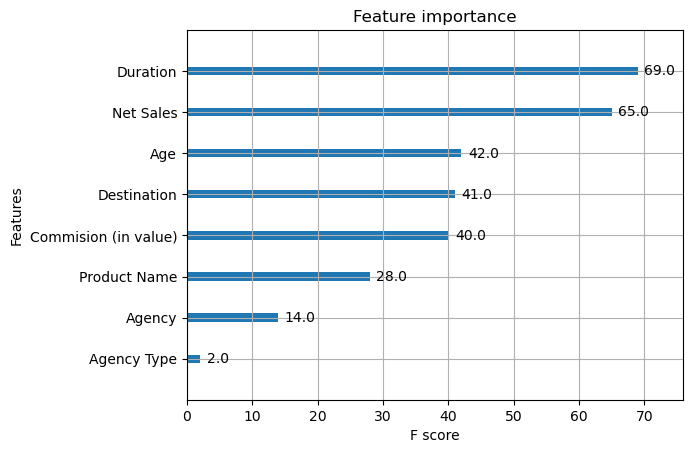

In [58]:
# XGBoost Feature Importance
plot_importance(xgbr_un)
plt.show()

As an additional analysis to see the dynamic significance of each individual data to the prediction, a SHAP summary plot is also generated below. Some of the results below are also confirming the feature importance above.

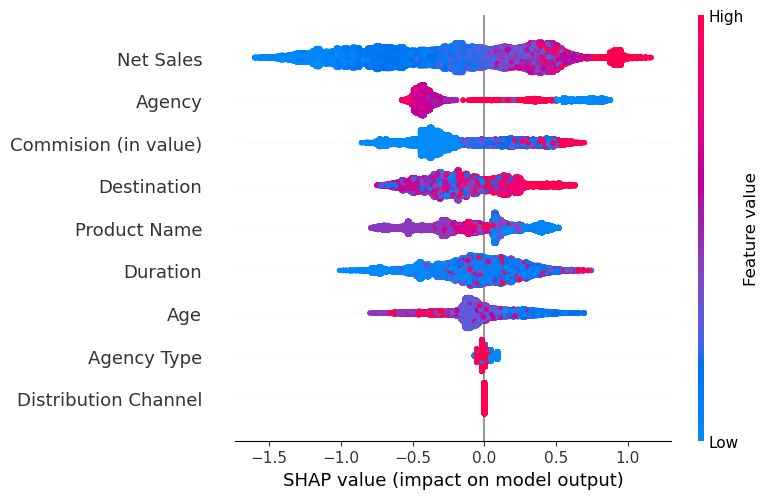

In [59]:
shap_values = shap.TreeExplainer(xgbr_un).shap_values(x)
shap.summary_plot(shap_values, x)

# Conclusion

The problem of predicting travel insurance claim is a binary classification task where the goal is to predict whether a customer will make a claim or not.
The dataset used for building the model was imbalanced, with the majority of customers not making a claim. This can lead to biased model performance, and thus, data resampling techniques were used to address this issue.
Various machine learning algorithms were evaluated, and the XGBoost algorithm was found to be the best performing algorithm based on the evaluation metrics used.
The feature importance analysis showed that the Duration,Net Sales, Age,Destination, and Commission  were the Top 5 important features for predicting the claim probability.
The final model achieved an accuracy of 75% and an AUC score of 0.747 on the test data, which indicates that it can predict whether a customer will make a claim or not with high accuracy.